In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from pinecone import Pinecone
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
# Load processed dataset
df = pd.read_csv('../data/intern_data_ikarus_processed.csv')

print(f"📊 Dataset loaded: {len(df)} products")
print(f"Columns: {list(df.columns)}")
df.head()


📊 Dataset loaded: 305 products
Columns: ['title', 'brand', 'description', 'price', 'categories', 'images', 'manufacturer', 'package_dimensions', 'country_of_origin', 'material', 'color', 'uniq_id', 'price_numeric', 'images_list', 'combined_text']


,title,brand,description,price,categories,images,manufacturer,package_dimensions,country_of_origin,material,color,uniq_id,price_numeric,images_list,combined_text
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...",GOYMFK,"multiple shoes, coats, hats, and other items E...",$24.99,"['Home & Kitchen', 'Storage & Organization', '...",['https://m.media-amazon.com/images/I/416WaLx1...,GOYMFK,"2.36""D x 7.87""W x 21.6""H",China,Metal,White,02593e81-5c09-5069-8516-b0b29f439ded,24.99,"[""['https://m.media-amazon.com/images/I/416WaL...","GOYMFK 1pc Free Standing Shoe Rack, Multi-laye..."
1,"subrtex Leather ding Room, Dining Chairs Set o...",subrtex,subrtex Dining chairs Set of 2,NaN,"['Home & Kitchen', 'Furniture', 'Dining Room F...",['https://m.media-amazon.com/images/I/31SejUEW...,Subrtex Houseware INC,"18.5""D x 16""W x 35""H",NaN,Sponge,Black,5938d217-b8c5-5d3e-b1cf-e28e340f292e,-1.00,"[""['https://m.media-amazon.com/images/I/31SejU...","subrtex Leather ding Room, Dining Chairs Set o..."
2,Plant Repotting Mat MUYETOL Waterproof Transpl...,MUYETOL,NaN,$5.98,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",['https://m.media-amazon.com/images/I/41RgefVq...,MUYETOL,"26.8""L x 26.8""W",NaN,Polyethylene,Green,b2ede786-3f51-5a45-9a5b-bcf856958cd8,5.98,"[""['https://m.media-amazon.com/images/I/41Rgef...",Plant Repotting Mat MUYETOL Waterproof Transpl...
3,"Pickleball Doormat, Welcome Doormat Absorbent ...",VEWETOL,The decorative doormat features a subtle textu...,$13.99,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doo...",['https://m.media-amazon.com/images/I/61vz1Igl...,Contrence,"24""L x 16""W",NaN,Rubber,A5589,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,13.99,"[""['https://m.media-amazon.com/images/I/61vz1I...","Pickleball Doormat, Welcome Doormat Absorbent ..."
4,JOIN IRON Foldable TV Trays for Eating Set of ...,JOIN IRON Store,Set of Four Folding Trays With Matching Storag...,$89.99,"['Home & Kitchen', 'Furniture', 'Game & Recrea...",['https://m.media-amazon.com/images/I/41p4d4VJ...,NaN,"18.9""D x 14.2""W x 26""H",NaN,Iron,Grey Set of 4,bdc9aa30-9439-50dc-8e89-213ea211d66a,89.99,"[""['https://m.media-amazon.com/images/I/41p4d4...",JOIN IRON Foldable TV Trays for Eating Set of ...


In [3]:
print("🤖 Loading Sentence Transformer Model...")
print("="*60)

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✅ Model loaded: all-MiniLM-L6-v2")
print(f"   Embedding dimension: 384")
print(f"   Max sequence length: {model.max_seq_length}")


🤖 Loading Sentence Transformer Model...
✅ Model loaded: all-MiniLM-L6-v2
   Embedding dimension: 384
   Max sequence length: 256


In [4]:
print("📝 Creating combined text representations...")
print("="*60)

# Create combined text from multiple fields
def create_combined_text(row):
    text_parts = []
    
    if pd.notna(row['title']):
        text_parts.append(str(row['title']))
    if pd.notna(row['brand']):
        text_parts.append(f"Brand: {row['brand']}")
    if pd.notna(row['description']):
        text_parts.append(str(row['description'])[:200])
    if pd.notna(row['material']):
        text_parts.append(f"Material: {row['material']}")
    if pd.notna(row['color']):
        text_parts.append(f"Color: {row['color']}")
    
    return " ".join(text_parts)

# Apply to all products
df['text_for_embedding'] = df.apply(create_combined_text, axis=1)

print(f"✅ Created text representations for {len(df)} products")
print(f"\nExample text:")
print(df['text_for_embedding'].iloc[0][:300] + "...")


📝 Creating combined text representations...
✅ Created text representations for 305 products

Example text:
GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway Brand: GOYMFK multiple shoes, coats, hats, and other items Easy to assemble: Includes all necessary hardware and instructions for easy assembly Versatile: Perfect for use in liv...


In [5]:
print("🔄 Generating embeddings for all products...")
print("="*60)

# Generate embeddings
texts = df['text_for_embedding'].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

print(f"\n✅ Generated embeddings")
print(f"   Shape: {embeddings.shape}")
print(f"   Total vectors: {embeddings.shape[0]}")
print(f"   Dimensions per vector: {embeddings.shape[1]}")

# Add to dataframe
df['embedding'] = list(embeddings)


🔄 Generating embeddings for all products...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Generated embeddings
   Shape: (305, 384)
   Total vectors: 305
   Dimensions per vector: 384


In [6]:
print("🔍 Testing Recommendation System with Cosine Similarity")
print("="*60)

def get_recommendations(query, top_k=5):
    """Get product recommendations based on query"""
    
    # Generate query embedding
    query_embedding = model.encode([query])[0]
    
    # Calculate similarities
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    
    # Get top k indices
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    # Get recommendations
    recommendations = []
    for idx in top_indices:
        recommendations.append({
            'product_id': df.iloc[idx]['uniq_id'],
            'title': df.iloc[idx]['title'],
            'brand': df.iloc[idx]['brand'],
            'similarity_score': similarities[idx]
        })
    
    return recommendations

# Test queries
test_queries = [
    "modern sofa",
    "wooden dining table",
    "office chair",
    "bedroom furniture"
]

print("Testing recommendation system with sample queries:\n")

for query in test_queries:
    print(f"Query: '{query}'")
    print("-" * 60)
    
    recs = get_recommendations(query, top_k=3)
    
    for i, rec in enumerate(recs, 1):
        print(f"  {i}. {rec['title'][:60]}...")
        print(f"     Brand: {rec['brand']}")
        print(f"     Similarity: {rec['similarity_score']:.4f}")
        print()
    
    print("=" * 60 + "\n")

print("✅ Recommendation system working!")


🔍 Testing Recommendation System with Cosine Similarity
Testing recommendation system with sample queries:

Query: 'modern sofa'
------------------------------------------------------------
  1. PONTMENT Foot Stool Leather Footstool Solid Wood Vintage Foo...
     Brand: PONTMENT
     Similarity: 0.5806

  2. Karl home Accent Chair Mid-Century Modern Chair with Pillow ...
     Brand: Karl home Store
     Similarity: 0.5625

  3. Dewhut Oversized Pumpkin Couch Accent Chair, Modern Comfy Ve...
     Brand: Dewhut Store
     Similarity: 0.5576


Query: 'wooden dining table'
------------------------------------------------------------
  1. Flash Furniture Webb Commercial Grade 24" Round Blue Metal I...
     Brand: Flash Furniture Store
     Similarity: 0.6391

  2. FLYJOE Narrow Side Table with PU Leather Magazine Holder Rus...
     Brand: FLYJOE
     Similarity: 0.6035

  3. FurnitureR 27''H Round Drawer 2 Tiers Endtable Nightstand Sh...
     Brand: FurnitureR
     Similarity: 0.5707


Query

In [7]:
print("📊 Evaluating Recommendation Quality")
print("="*60)

# Sample evaluation queries with expected categories
evaluation_queries = {
    "sofa": "sofa",
    "chair": "chair",
    "table": "table",
    "bed": "bed",
    "desk": "desk"
}

results = []

for query, expected_keyword in evaluation_queries.items():
    recs = get_recommendations(query, top_k=10)
    
    # Count how many recommendations contain the expected keyword
    relevant = sum(1 for rec in recs if expected_keyword.lower() in rec['title'].lower())
    precision = relevant / len(recs)
    
    avg_similarity = np.mean([rec['similarity_score'] for rec in recs])
    
    results.append({
        'query': query,
        'precision': precision,
        'avg_similarity': avg_similarity,
        'relevant_count': relevant
    })
    
    print(f"Query: '{query}'")
    print(f"  Precision: {precision:.2%}")
    print(f"  Avg Similarity: {avg_similarity:.4f}")
    print(f"  Relevant Products: {relevant}/10")
    print()

# Overall metrics
avg_precision = np.mean([r['precision'] for r in results])
avg_similarity = np.mean([r['avg_similarity'] for r in results])

print("="*60)
print("OVERALL METRICS:")
print(f"  Average Precision: {avg_precision:.2%}")
print(f"  Average Similarity Score: {avg_similarity:.4f}")
print("="*60)


📊 Evaluating Recommendation Quality
Query: 'sofa'
  Precision: 70.00%
  Avg Similarity: 0.5164
  Relevant Products: 7/10

Query: 'chair'
  Precision: 100.00%
  Avg Similarity: 0.4803
  Relevant Products: 10/10

Query: 'table'
  Precision: 100.00%
  Avg Similarity: 0.4794
  Relevant Products: 10/10

Query: 'bed'
  Precision: 80.00%
  Avg Similarity: 0.3192
  Relevant Products: 8/10

Query: 'desk'
  Precision: 100.00%
  Avg Similarity: 0.5209
  Relevant Products: 10/10

OVERALL METRICS:
  Average Precision: 90.00%
  Average Similarity Score: 0.4632


📈 Visualizing Similarity Distribution


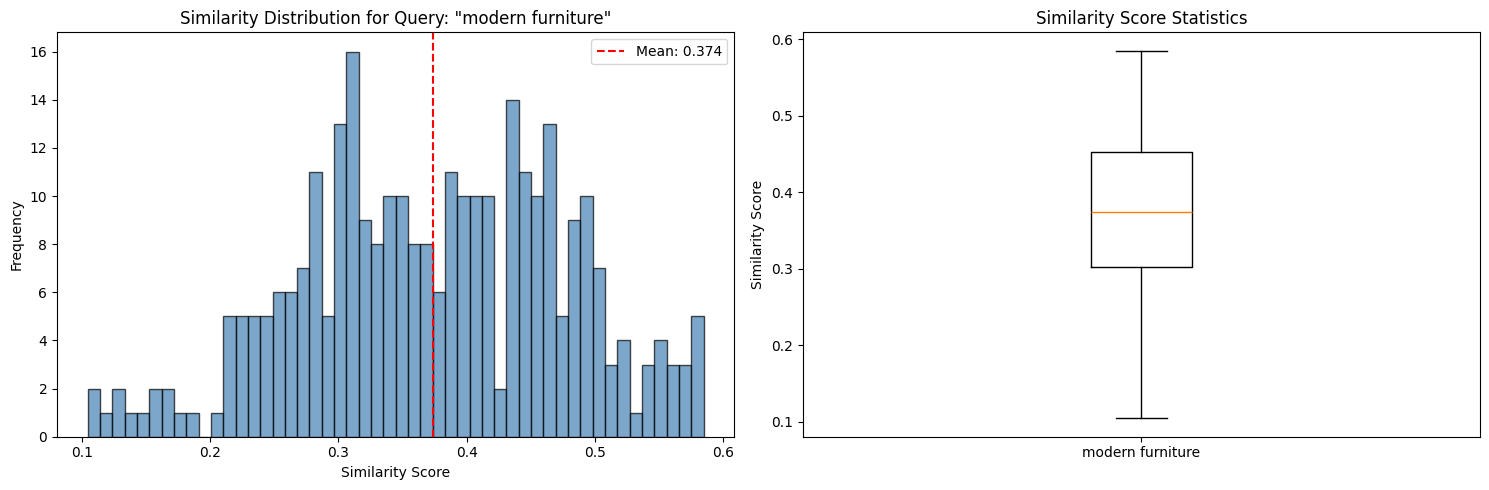

✅ Visualization complete
   Mean similarity: 0.3738
   Std deviation: 0.1032
   Min similarity: 0.1046
   Max similarity: 0.5848


In [8]:
print("📈 Visualizing Similarity Distribution")
print("="*60)

# Generate similarities for sample query
query = "modern furniture"
query_embedding = model.encode([query])[0]
similarities = cosine_similarity([query_embedding], embeddings)[0]

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(similarities, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Similarity Distribution for Query: "{query}"')
axes[0].axvline(similarities.mean(), color='red', linestyle='--', 
                label=f'Mean: {similarities.mean():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(similarities, vert=True)
axes[1].set_ylabel('Similarity Score')
axes[1].set_title('Similarity Score Statistics')
axes[1].set_xticklabels([query])

plt.tight_layout()
plt.show()

print(f"✅ Visualization complete")
print(f"   Mean similarity: {similarities.mean():.4f}")
print(f"   Std deviation: {similarities.std():.4f}")
print(f"   Min similarity: {similarities.min():.4f}")
print(f"   Max similarity: {similarities.max():.4f}")


In [9]:
print("🔗 Connecting to Pinecone Vector Database")
print("="*60)

# Load environment variables
load_dotenv(dotenv_path='../backend/.env')

api_key = os.getenv('PINECONE_API_KEY')

# Initialize Pinecone
pc = Pinecone(api_key=api_key)

# Get index
index_name = "furniture-products"
index = pc.Index(index_name)

# Get stats
stats = index.describe_index_stats()

print(f"✅ Connected to Pinecone")
print(f"   Index: {index_name}")
print(f"   Total vectors: {stats['total_vector_count']}")
print(f"   Dimension: {stats['dimension']}")
print("\n" + "="*60)

# Test query
print("\n🧪 Testing Pinecone query...")
test_query = "modern sofa"
query_embedding = model.encode([test_query]).tolist()

results = index.query(
    vector=query_embedding[0],
    top_k=3,
    include_metadata=True
)

print(f"\nQuery: '{test_query}'")
print("-" * 60)

for i, match in enumerate(results['matches'], 1):
    print(f"{i}. {match['metadata']['title'][:60]}...")
    print(f"   Brand: {match['metadata']['brand']}")
    print(f"   Similarity: {match['score']:.4f}")
    print()

print("✅ Pinecone integration working!")


🔗 Connecting to Pinecone Vector Database
✅ Connected to Pinecone
   Index: furniture-products
   Total vectors: 305
   Dimension: 384


🧪 Testing Pinecone query...

Query: 'modern sofa'
------------------------------------------------------------
1. FANYE Oversized 6 Seaters Modular Storage Sectional Sofa Cou...
   Brand: FANYE
   Similarity: 0.5985

2. Karl home Accent Chair Mid-Century Modern Chair with Pillow ...
   Brand: Karl home Store
   Similarity: 0.5710

3. Dewhut Oversized Pumpkin Couch Accent Chair, Modern Comfy Ve...
   Brand: Dewhut Store
   Similarity: 0.5623

✅ Pinecone integration working!
